# Resistant-Genes Recommendation to help in Lung Cancer Research
> To find key drivers of resistance faster they built a hybrid recommendation system on top of a heterogeneous biomedical knowledge graph. In the absence of either training data or continuous feedback they approached recommendations as a multi-objective optimization problem. Genes were ranked based on trade-offs between diverse types of evidence linking them to potential mechanisms of EGFRi resistance. This unbiased approach narrowed down the number of targets from more than 3,000 to 36 and reduced hit identification time from months to minutes. Similar recommendation system frameworks could be applied to a range of related problems in drug discovery space.

- toc: true
- badges: true
- comments: true
- categories: [Drugs&Medicine, Healthcare, MultiObjective, Unsupervised]
- image:

## Introduction

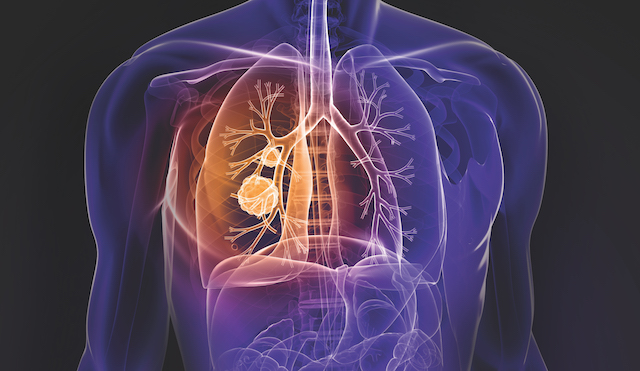

Resistance to EGFR inhibitors (EGFRi) is complex and only partly understood. It presents a major obstacle in treating non-small cell lung cancer (NSCLC). One of the most exciting new ways to find potential resistance markers involves running functional genetic screens, such as CRISPR, followed by manual triage of significantly enriched genes. This triage stage requires specialized knowledge and can take even experts a number of months to complete. To find key drivers of resistance faster they built a hybrid recommendation system on top of a heterogeneous biomedical knowledge graph. In the absence of either training data or continuous feedback they approached recommendations as a multi-objective optimization problem. Genes were ranked based on trade-offs between diverse types of evidence linking them to potential mechanisms of EGFRi resistance. This unbiased approach narrowed down the number of targets from more than 3,000 to 36 and reduced hit identification time from months to minutes. Similar recommendation system frameworks could be applied to a range of related problems in drug discovery space.

There are some challenges though in formulating this problem as a recommendation task:

1. An elementary unit of recommendation is not a simple self-contained item (e.g a gene), but rather a research direction accompanied by a biologically sound hypothesis.
2. Ultimate validation of recommendations is complex and often requires expensive and timeconsuming laboratory experiments, as opposed to users just ’selecting’ an item in a common non-biological recommendation scenario.
3. Unlike traditional applications, in a biomedical setting both implicit and explicit feedback is scarce, making it harder to tune and train models.
4. Ground truths are scarce and in most cases context-dependent which renders training challenging.
5. Due to the high cost associated with accepting a recommendation, an increased emphasis is placed on explainability and exposing causal reasoning paths behind a recommendation.

Despite these challenges, wider adoption of recommendation approaches holds plenty of opportunities to support and accelerate biological research. In this tutorial, we will build a recommendation system that finds key genes driving drug resistance. 

### System design

Followed a hybrid unsupervised recommendation approach which relies on content-based filtering. They formalized re-ranking of CRISPR hits as a multi-objective optimisation problem, where diverse and conflicting types of evidence supporting gene’s relevance are mapped to objectives. During the optimization procedure feasible solutions (genes) are identified and compared until no better can be found. A crucial component of such framework is a set of hybrid features. Each feature represents a distinct type of evidence, such as literature support, clinical and pre-clinical evidence. Along with the purely biological features, our recommendation system relied on data derived from a specially constructed heterogeneous biomedical knowledge graph. Knowledge graphs provide a convenient conceptual representation of relationships (edges) between entities (nodes). In the recommendation context knowledge graphs gain popularity as a way to introduce content-specific information and also to provide explanations for the resulting recommendations. In addition, graph-based recommendations were shown to achieve higher precision and accuracy compared to alternative approaches. They used graph structural information together with graph-based representations to express relevance of a gene in the resistance context. Our assumption was that by combining graph-derived features with clinical ones they could discover unobvious genes that drive drug resistance in lung cancer.

> In multi-objective optimization, with multiple competing objectives a singular best solution often cannot be found. However, one can identify a set of optimal solutions based on the notion of Pareto dominance. A solution x1 dominates solution x2 if two conditions are true: 1) solution x1 is not worse than x2 according to all objectives; 2) solution x1 is strictly better than solution x2 according to at least one objective. If both conditions are true, we can say that x1 dominates x2, which is equal to x2 being dominated by x1. In other words, dominant solutions can not be improved any further without compromising at least one of the other objectives. A set of such dominant solutions forms a Pareto front, which combines the best trade-off combinations between competing objectives.

## Setup

In [2]:
%load_ext rpy2.ipython

In [3]:
!git clone https://github.com/AstraZeneca/skywalkR.git

Cloning into 'skywalkR'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 110 (delta 45), reused 59 (delta 19), pack-reused 0
Receiving objects: 100% (110/110), 1011.12 KiB | 7.49 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
%cd skywalkR/

## Data Exploration

In [ ]:
import os
import pandas as pd

In [13]:
os.listdir('./data')

['heatmap_data.tsv',
 'app_data.csv',
 'sample_data.csv',
 'mtcars.csv',
 'nlp_allowed.csv']

In [9]:
app_df = pd.read_csv('./data/app_data.csv')
app_df.head()

,gene,annotation,ensembl_gene_id,depmap,trct_ab,trct_sm,trct_om,lit_egfr,lit_nsclc,L2_egfr,L2_nsclc,n_neighbours,n_edges,degree,pagerank,betweenness,full_screen,KO_osi,KO_gefi,KO_all,A_osi,A_gefi,A_all,clin_ES1,clin_ES2,clin_ES3,RNAseq_adjpval,RNAseq_LFC
0,AASS,aminoadipate-semialdehyde synthase,ENSG00000008311,nonessential,0,6,0,0,0,27.7,17.8,485,564,4,0.332499,70.180022,1,0,0,0,1,0,1,0.0,0.0,0.0,1.310000e-04,1.1
1,ABAT,4-aminobutyrate aminotransferase,ENSG00000183044,nonessential,0,9,0,0,0,31.5,18.6,0,0,0,0.000000,0.000000,1,0,0,0,0,1,1,0.0,0.0,0.0,6.300000e-06,0.7
2,ABCB10,ATP binding cassette subfamily B member 10,ENSG00000135776,essential,3,6,0,0,0,27.9,19.5,449,621,1,0.209855,0.000000,2,0,0,0,1,1,2,0.0,0.0,0.0,6.910000e-07,-0.7
3,ABCG2,ATP binding cassette subfamily G member 2 (Jun...,ENSG00000118777,nonessential,6,6,0,0,0,32.1,26.9,6248,11244,3,0.290778,2.768582,1,0,0,0,0,1,1,0.0,0.0,0.0,1.000000e+00,0.0
4,ABHD16B,abhydrolase domain containing 16B,ENSG00000183260,nonessential,0,0,0,0,0,25.2,16.5,91,104,0,0.150000,0.000000,1,0,0,0,0,1,1,0.0,0.0,0.0,1.000000e+00,0.0


In [11]:
app_df.describe()

,trct_ab,trct_sm,trct_om,lit_egfr,lit_nsclc,L2_egfr,L2_nsclc,n_neighbours,n_edges,degree,pagerank,betweenness,full_screen,KO_osi,KO_gefi,KO_all,A_osi,A_gefi,A_all,clin_ES1,clin_ES2,clin_ES3,RNAseq_adjpval,RNAseq_LFC
count,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1.550000e+03,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000,1.550000e+03,1550.000000
mean,1.923226,1.603871,0.138710,0.353548,0.136129,28.326774,21.505419,1266.730968,1735.543226,19.647742,0.938783,1.923827e+04,1.487742,0.236774,0.220000,0.456774,0.659355,0.371613,1.030968,0.015129,0.000206,0.010510,6.029311e-01,0.037613
std,2.452632,2.788751,1.086087,5.488544,2.379474,7.878291,8.404409,3621.302533,4880.519357,53.558157,2.151909,1.011528e+05,0.917960,0.588300,0.484745,0.956984,0.635784,0.524390,0.877417,0.093527,0.004216,0.073233,4.890918e-01,0.658949
min,0.000000,0.000000,0.000000,0.000000,0.000000,9.700000,10.400000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.460000e-22,-3.900000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,24.100000,17.425000,235.000000,277.000000,1.000000,0.202900,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.185000e-04,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,26.300000,19.300000,438.000000,554.000000,5.000000,0.386266,2.667967e+02,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000
75%,5.000000,3.000000,0.000000,0.000000,0.000000,29.600000,21.500000,941.750000,1280.500000,18.000000,0.921514,6.823960e+03,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000
max,9.000000,9.000000,9.000000,173.000000,66.000000,52.900000,49.700000,62389.000000,75682.000000,1058.000000,44.220294,2.238059e+06,8.000000,5.000000,3.000000,8.000000,5.000000,3.000000,8.000000,1.000000,0.110000,1.000000,1.000000e+00,3.200000


In [12]:
app_df.describe(include=['O'])

,gene,annotation,ensembl_gene_id,depmap
count,1550,1494,1550,1550
unique,1460,1405,1550,3
top,TFPT,TCF3 fusion partner,ENSG00000124664,nonessential
freq,10,10,1,1238


In [16]:
nlp_allowed = pd.read_csv('./data/nlp_allowed.csv')
nlp_allowed.head()

,genes,genes_names
0,ENSG00000085563,ABCB1
1,ENSG00000118777,ABCG2
2,ENSG00000097007,ABL1
3,ENSG00000151694,ADAM17
4,ENSG00000142208,AKT1


In [17]:
nlp_allowed.describe()

,genes,genes_names
count,174,174
unique,174,174
top,ENSG00000135446,VIM
freq,1,1


In [19]:
heatmap_data = pd.read_csv('./data/heatmap_data.tsv', sep='\t')
heatmap_data.head()

,cluster,ensembl_gene_id,counts,genes_num,genes_names
0,cl_1,ENSG00000087088 ENSG00000141510 ENSG00000171791,572,3,BAX
1,cl_1,ENSG00000087088 ENSG00000141510 ENSG00000171791,572,3,TP53
2,cl_1,ENSG00000087088 ENSG00000141510 ENSG00000171791,572,3,BCL2
3,cl_2,ENSG00000091831 ENSG00000141736 ENSG00000148773,352,3,ESR1
4,cl_2,ENSG00000091831 ENSG00000141736 ENSG00000148773,352,3,ERBB2


In [20]:
heatmap_data.describe()

,counts,genes_num
count,15295.000000,15295.000000
mean,5.442759,3.737888
std,14.882196,0.982926
min,2.000000,3.000000
25%,2.000000,3.000000
50%,3.000000,3.000000
75%,4.000000,4.000000
max,572.000000,11.000000


In [21]:
heatmap_data.describe(include=['O'])

,cluster,ensembl_gene_id,genes_names
count,15295,15295,15295
unique,4314,4314,174
top,cl_2759,ENSG00000087088 ENSG00000089685 ENSG0000009696...,AKT1
freq,11,11,1106


## SkywalkR App

This Shiny app is tailored to finding genes driving resistance in EGFR mutant Non-small Cell Line Cancer (NSCLC). The app will automatically load required data. To re-rank genes set directions of optimization by moving sliders and press rank button.

In [4]:
%%R

if (!requireNamespace("remotes"))
  install.packages("remotes")

remotes::install_github("rstudio/renv")

renv::restore()

R[write to console]: Loading required namespace: remotes

R[write to console]: Skipping install of 'renv' from a github remote, the SHA1 (6b3a20ef) has not changed since last install.
  Use `force = TRUE` to force installation




This project has not yet been activated.
Activating this project will ensure the project library is used during restore.
Please see `?renv::activate` for more details.

Would you like to activate this project before restore? [Y/n]: Y
* Project '/content/skywalkR' loaded. [renv 0.13.2-102]
The following package(s) will be updated:

# GitHub =============================
- renv   [rstudio/renv@HEAD: 6b3a20ef -> f1dde0e9]

Do you want to proceed? [y/N]: y
Installing renv [0.13.2-102] ...
	OK [linked cache]
The following package(s) have been updated:

	renv [installed version 0.13.2-102 != loaded version 0.14.0-3]

Consider restarting the R session and loading the newly-installed packages.



In [ ]:
#collapse-hide
%%R

library(shiny)
library(shinydashboard)
library(tidyverse)
library(magrittr)
library(tidyr)
library(scales)
library(shinyWidgets)
library(formattable)
library(DT)
library(d3heatmap)
library(R.utils)
source("R/server_utils.R", local = TRUE)
source("R/ui_utils.R", local = TRUE)

# constants & input files
USUAL_OPTIONS <- c('low', 'exclude', 'high')
DISTANCE_OPTIONS <- c('close', 'exclude', 'far') 
TOTAL_OBJECTIVES <- 24 
DATA <- read_csv('data/app_data.csv', quoted_na = FALSE)
HEATMAP_DATA <- read_tsv('data/heatmap_data.tsv')
NLP <- read_csv('data/nlp_allowed.csv')

ui <- dashboardPage(
  skin = 'purple',
  dashboardHeader(title = "skywalkR"),
  dashboardSidebar(
    sidebarMenu(
      id = 'mysidebar',
      menuItem(
        "Essentiality",
        tabName = "widgets",
        icon = icon("shapes"),
        radioButtons(
          inputId = 'flt_1',
          label = "DepMap",
          choices = list('essential', 'nonessential'),
          selected = 'nonessential'
        )
      ),
      menuItem(
        "Tractability",
        tabName = "dashboard",
        icon = icon("capsules"),
        sliderTextInput01(
          "obj_1", 
          "tractability, antibodies",
          "exclude"
        ),
        sliderTextInput01(
          "obj_2", 
          "tractability, small molecules",
          "exclude"
        ),
        sliderTextInput01(
          "obj_3", 
          "tractability, other modalities",
          "exclude")
      ),
      menuItem(
        "Literature support",
        tabName = "widgets",
        icon = icon("graduation-cap"),
        sliderTextInput01(
          "obj_4", 
          "# of papers, gene in resistance context + EGFR",
          "high"
        ),
        sliderTextInput01(
          "obj_5", 
          "# of papers, gene in resistance context + NSCLC",
          "high")
      ),
      menuItem(
        "Graph-derived",
        tabName = "widgets",
        icon = icon("project-diagram"),
        sliderTextInput01(
          "obj_6", 
          "L2 distance to EGFR",
          'exclude',
          DISTANCE_OPTIONS
        ),
        sliderTextInput01(
          "obj_7", 
          "L2 distance to NSCLC",
          'exclude',
          DISTANCE_OPTIONS
        ),
        sliderTextInput01(
          "obj_8", 
          "# uniqie neighbours connected to a node in full KG",
          'exclude'
        ),
        sliderTextInput01(
          "obj_9", 
          "# edges connected to a node in full BIKG",
          'exclude'
        ),
        sliderTextInput01(
          "obj_10", 
          "node degree in PPI subgraph extracted from BIKG",
          'exclude'
        ),
        sliderTextInput01(
          "obj_10", 
          "node degree in PPI subgraph extracted from BIKG",
          'exclude'
        ),
        sliderTextInput01(
          "obj_11", 
          "pagerank, (~ popularity) of a node in PPI subgraph",
          'exclude'
        ),
        sliderTextInput01(
          "obj_12", 
          "betweenness (~ node's influence) in PPI subgraph",
          'exclude'
        )
      ),
      menuItem(
        "Consistency",
        tabName = "widgets",
        icon = icon("check-double"),
        sliderTextInput01(
          'obj_13',
          "CRISPRn+CRISPRa, consistency in osimertinib-treated cell lines",
           'high'
        ),
        sliderTextInput01(
          'obj_14',
          "CRISPRn, consistency in osimertinib-treated cell lines",
          'exclude'
        ),
        sliderTextInput01(
          'obj_15',
          "CRISPRn, consistency in gefitinib-treated cell lines",
          'exclude'
        ),
        sliderTextInput01(
          'obj_16',
          "CRISPRn, consistency in the full EGFR screen",
          'exclude'
        ),
        sliderTextInput01(
          'obj_17',
          "CRISPRa, consistency in osimertinib-treated cell lines",
          'exclude'
        ),
        sliderTextInput01(
          'obj_18',
          "CRISPRa, consistency in gefitinib-treated cell lines",
          'exclude'
        ),
        sliderTextInput01(
          'obj_19',
          "CRISPRa, consistency in the full EGFR screen",
          'exclude'
        )
      ),
      menuItem(
        "Clinical relevance",
        tabName = "widgets",
        icon = icon("user-md"),
        sliderTextInput01(
          'obj_20',
          "Clinical enrichment score 1, RESPONDERS vs RESISTANT",
          'high'
        ),
        sliderTextInput01(
          'obj_21',
          "Clinical enrichment score 2, RESPONDERS vs RESISTANT",
          'high'
        ),
        sliderTextInput01(
          'obj_22',
          "Clinical enrichment score, cross-studies",
          'high'
        )
      ),
      menuItem(
        "Preclinical evidence",
        tabName = "widgets",
        icon = icon("dna"),
        sliderTextInput01(
          'obj_23',
          "RNAseq, adjusted p-value",
          'low'
        ),
        sliderTextInput01(
          'obj_24',
          "RNAseq, log2 fold change",
          'high'
        )
      ),
      actionBttn(
        inputId = "rank",
        label = "rank!",
        style = "gradient",
        color = "royal",
        icon = icon("random"),
        size = 'sm'
      ),
      actionBttn(
         inputId = "reset",
         label = "reset",
         style = "gradient",
         color = "primary",
         icon = icon("redo-alt"),
         size = 'sm'
      )
    )
  ),
  
  dashboardBody(
    fluidRow(
      box(
        title = tagList(shiny::icon("lightbulb"), "How it works"),
        status = NULL, 
        solidHeader = TRUE,
        collapsible = TRUE,
        includeMarkdown('docs/intro.md'),
        width = 12),
      tabBox(
        title = 'Optimal hits, tab view',
        id = 'tabset1',
        width = 12,
        tabPanel(
          title = tagList(shiny::icon("list-alt"), "Result"),
          pickerInput(
            inputId = "SortMenu",
            label = "Sort top genes by", 
            choices = list(
              'essentiality (depmap)' = c("depmap"),
              'tractability' = c("trct_ab", "trct_sm", 'trct_om'),
              'literature support' = c("lit_egfr", "lit_nsclc"),
              'graph-derived' = c("L2_egfr", "L2_nsclc",
                                   'n_neighbours', 'n_edges',
                                    'degree', 'pagerank', 'betweenness'),
              'consistency in CRISPR screens' = c('full_screen',
                                                  'KO_osi', 'KO_gefi', 'KO_all',
                                                  'A_osi', 'A_gefi', 'A_all'),
              'clinical relevance' = c('clin_ES1', 'clin_ES2', 'clin_ES3'),
              'expression' = c('RNAseq_adjpval', 'RNAseq_LFC')),
            selected = 'full_screen',
            options = list(size = 5)),
          DT::dataTableOutput("TopTable"),
          downloadButton('TopDownload',"Download Top results")),
        tabPanel(
          title = tagList(shiny::icon("question"), "Variables explained"),
          includeMarkdown('docs/variables_explained.md')
        )
      ),
      box(
      title = 'heatmap controls',
      id = 'tabsetNLP',
      width = 2,
      height="664px",
      collapsible = TRUE,
      sliderInput("cluster", "min cluster size",
                  value = 4,
                  min = 3,
                  max = 10,
                  width = '300px'),
      sliderInput("papers", "min number of papers with gene cluster",
                  value = 4,
                  min = 2,
                  max = 50,
                  width = '300px'),
      pickerInput(
        inputId = "gene",
        label = "select a gene, only genes found in NLP clusters are shown", 
        choices = NLP$genes,
        selected = 'ENSG00000171862',
        choicesOpt = list(
          subtext = paste("symbol", 
                          NLP$genes_names,
                          sep = ": ")))),
      box(
      title = 'heatmap showing multi-term gene co-occurrence in cancer resistance context',
      id = 'heatmapTab',
      width = 10,
      collapsible = TRUE,
      d3heatmapOutput("heatmap", width = "100%", height = '600px')
      ),
      tabBox(
        title = 'Optimal hits, relative view',
        id = 'tabset2',
        width = 12,
        tabPanel(
          title = tagList(shiny::icon("list-alt"), "Optimal hits"),
          plotOutput("ParetoBar", height = '1300px')),
        tabPanel(
          title = tagList(shiny::icon("question"), "Plot explained"),
          includeMarkdown('docs/pareto_bar_explained.md')
        )
      ),
      box(
        title = "Full dataset",
        solidHeader = TRUE,
        collapsible = TRUE,
        DT::dataTableOutput("table"),
        width = 12
      ),
      tabBox(
        id = 'tabset0',
        width = 12,
        tabPanel(
          title = tagList(shiny::icon("chart-bar"), "Distribution of Pareto levels"),
          plotOutput("ParetoHist")),
        tabPanel(
          title = tagList(shiny::icon("question"), "Plot explained"),
          includeMarkdown('docs/pareto_hist_explained.md')
        ))
    ))
)

server <- function(input, output, session) {
  
  # data for plots & full table
  genericdata <- reactive({

    # depends on rank action button to delay ranking
    input$rank

    isolate({
      # extract directions for objectives
      all_objectives <- NULL
      for (i in seq(TOTAL_OBJECTIVES)) {
        all_objectives <- c(all_objectives,
                            input[[paste0("obj_", as.character(i))]])
      }
      
      data.prt <- any_filter(DATA, flt_d = input$flt_1) %>%
        mutate_at(c('RNAseq_LFC'), abs) %>%
        dplyr::select(-c('depmap'))

      head(data.prt)
      res <- pareto_helper(data.prt,
        all_objectives,
        num_objectives = TOTAL_OBJECTIVES,
        return_pref = FALSE)
    })
  })
  
  # top hits for top view and download button
  topdata <- reactive({
    
    res <- genericdata()
    d <- res %>%
      left_join(dplyr::select(DATA,
                              c(gene, ensembl_gene_id, depmap, 
                                contains('LFC'))),
                by = c('gene', 'ensembl_gene_id')) %>%
      mutate(RNAseq_LFC.x = RNAseq_LFC.y ) %>%
      dplyr::rename(RNAseq_LFC = RNAseq_LFC.x) %>%
      dplyr::select(-c(contains('LFC.y')))
  })

  output$TopTable <- DT::renderDataTable({

    # reuse reactive data, same as for TopDownload
    res <- topdata()
    radio <- input$SortMenu
   
    d <- res %>%
      dplyr::filter(.level == 1) %>%
      dplyr::select(-c(.level)) %>%
      arrange(desc(!!sym(radio)))

    ff <- formattable(
      d,
      list(
        area(col = trct_ab:trct_om) ~ color_bar('#8dd3c7'),
        area(col = c(lit_nsclc,lit_egfr)) ~ color_bar('#9ebcda'), 
        full_screen = color_bar('#fb9a99'),
        area(col = KO_osi:KO_all) ~ color_bar('#fdb863'), 
        area(col = A_osi:A_all) ~ color_bar('#fee0b6'), 
        area(col = L2_egfr:L2_nsclc) ~ color_bar('#d8daeb'), 
        area(col = n_neighbours:n_edges) ~ color_bar('#bc80bd'),
        degree = color_bar('#b2df8a'),
        pagerank = color_bar('#b2df8a'),
        betweenness = color_bar('#b2df8a'),
        area(col = c(RNAseq_LFC)) ~ sign_formatter,
        area(col = c(depmap)) ~ depmap_formatter,
        area(col = clin_ES1:clin_ES3) ~ color_bar('#fb8072')
      )) 

   as.datatable(
      ff,
      escape = F,
      rownames= F,
      extensions = list("ColReorder" = NULL,
                        "Buttons" = NULL,
                        "FixedColumns" = list(leftColumns=1)),
      options = list(
        dom = 'BRfrltpi',
        scrollX = TRUE,
        ordering = FALSE,
        lengthMenu = list(c(10, 20, 50, -1), c('10', '20', '50', 'All')),
        ColReorder = TRUE,
        buttons = list(I('colvis')) 
      )
    )
  })

  output$TopDownload <- downloadHandler(
    filename = function(){'BIKG_skywalkR_optimal_genes.csv'},
    content = function(fname){
      write.csv(dplyr::filter(topdata(), .level == 1), fname)
    }
  )
  
  output$heatmap <- renderD3heatmap({
  
    cooc_flat <- HEATMAP_DATA %>%
      dplyr::filter(grepl(input$gene, ensembl_gene_id)) %>%
      dplyr::filter(counts >= input$papers,
                    genes_num >= input$cluster) 

    cooc_wide <- cooc_flat[c('cluster', 'counts', 'genes_names')] %>%
      tidyr::pivot_wider(names_from = cluster, values_from = counts,
                         values_fill = 0) %>%
      tibble::column_to_rownames(var = "genes_names")
    
    cooc_mat <- as.matrix(cooc_wide)
    
    if (ncol(cooc_mat) <= 1) {
      xx <- c('number of papers:',cooc_flat$counts[1],
              'genes in the cluster:', cooc_flat$genes_names)
      x <- R.utils::insert(xx, ats=2:length(xx), values = '\n')
      
      stop('Not enough rows to cluster; Please reduce min settings 
            or select another gene \n',
           'Found the following clusters with the gene of interest: \n',
           x)
    } else {
    d3heatmap(cooc_mat,
              colors = c('#d9d9d9',
                         colorRampPalette(brewer.pal(8, "Paired"))(25)))
    }
  })
  
  output$ParetoBar <- renderPlot({

    res <- genericdata()
    rescale2 <- function(x){scales::rescale(x, to = c(-1,1))}

    # faceted bar plot:
    top_genes <- res %>%
      dplyr::filter(.level == 1) %>%
      arrange(desc(KO_all)) %>%
      head(n = 35) %>%
      mutate_at(c(4:(ncol(res) - 1)), rescale2) %>%
      dplyr::select(-c(contains('pval'),
                       ensembl_gene_id, .level, annotation))

    # gather everything before ploting
    top_genes_tall <- gather(top_genes,
                             key = 'objective',value = 'value',
                            -c(gene))

    # lock levels
    top_genes_tall$gene <- factor(top_genes_tall$gene,
                                  levels = top_genes$gene)

    top_genes_tall$objective <- factor(top_genes_tall$objective,
      levels = rev(c(names(DATA[4:27]), 'RNAseq_LFC')))

    p <- ggplot(top_genes_tall,
      aes(x = objective,
        y = value,
        fill = value > 0)) +
      geom_bar(stat = 'identity') +
      facet_wrap(~ gene, nrow = 5, scales = 'free_y') +
      coord_flip() +
      theme(legend.position = 'none') +
      xlab('genes') +
      scale_fill_manual(values = c("#8da0cb", "#fc8d62")) +
      theme(legend.position = 'none',
        plot.title = element_text(hjust = 0.5, size = 18),
        axis.title.x = element_text(size = 16),
        axis.title.y = element_text(size = 16))
    p

  })

  output$ParetoHist <- renderPlot({

    res <- genericdata()

    res %>%
      mutate(flag = ifelse(.level == 1, 'T', 'F')) %>%
      dplyr::filter(.level <= 25) %>%
      ggplot(aes(as.factor(.level), fill = flag)) +
      geom_bar(colour = 'black') +
      xlab('Pareto level') +
      ylab('Number of genes') +
      theme(legend.position = 'none',
        plot.title = element_text(hjust = 0.5, size = 18),
        axis.title.x = element_text(size = 16),
        axis.title.y = element_text(size = 16)) +
      scale_fill_manual(values = c("#d9d9d9", "#66c2a5"))
  })

  output$table <-  DT::renderDataTable({
    # topdata, not filtered by levels
    res <- topdata()
    DT::datatable(res, options = list( scrollX = TRUE))
  })
  
  # slider resetting 
  initialInputs <- isolate(reactiveValuesToList(input))
  observe({
    # save initial values of dynamic inputs
    inputValues <- reactiveValuesToList(input)
    # modify a possibly nested list recursively
    initialInputs <<- utils::modifyList(inputValues, initialInputs)
  })

  observeEvent(input$reset, {
    update_helper <- function(my_input){
      updateSliderTextInput(
        session = session,
        inputId = my_input,
        selected = initialInputs[[my_input]]
      )
    }

    lapply(paste0('obj_', c(1:TOTAL_OBJECTIVES)), update_helper)

    # reset essentiality filter
    flt_value <- initialInputs[['flt_1']]
    session$sendInputMessage('flt_1', list(value = flt_value))
  })
}

opts <- list(host = "127.0.0.1", port = 5460)

shinyApp(ui, server, options=opts)

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  gene = col_character(),
  annotation = col_character(),
  ensembl_gene_id = col_character(),
  depmap = col_character()
)

R[write to console]: See spec(...) for full column specifications.

R[write to console]: Parsed with column specification:
cols(
  cluster = col_character(),
  ensembl_gene_id = col_character(),
  counts = col_double(),
  genes_num = col_double(),
  genes_names = col_character()
)

R[write to console]: Parsed with column specification:
cols(
  genes = col_character(),
  genes_names = col_character()
)

R[write to console]: 
Listening on http://127.0.0.1:5460



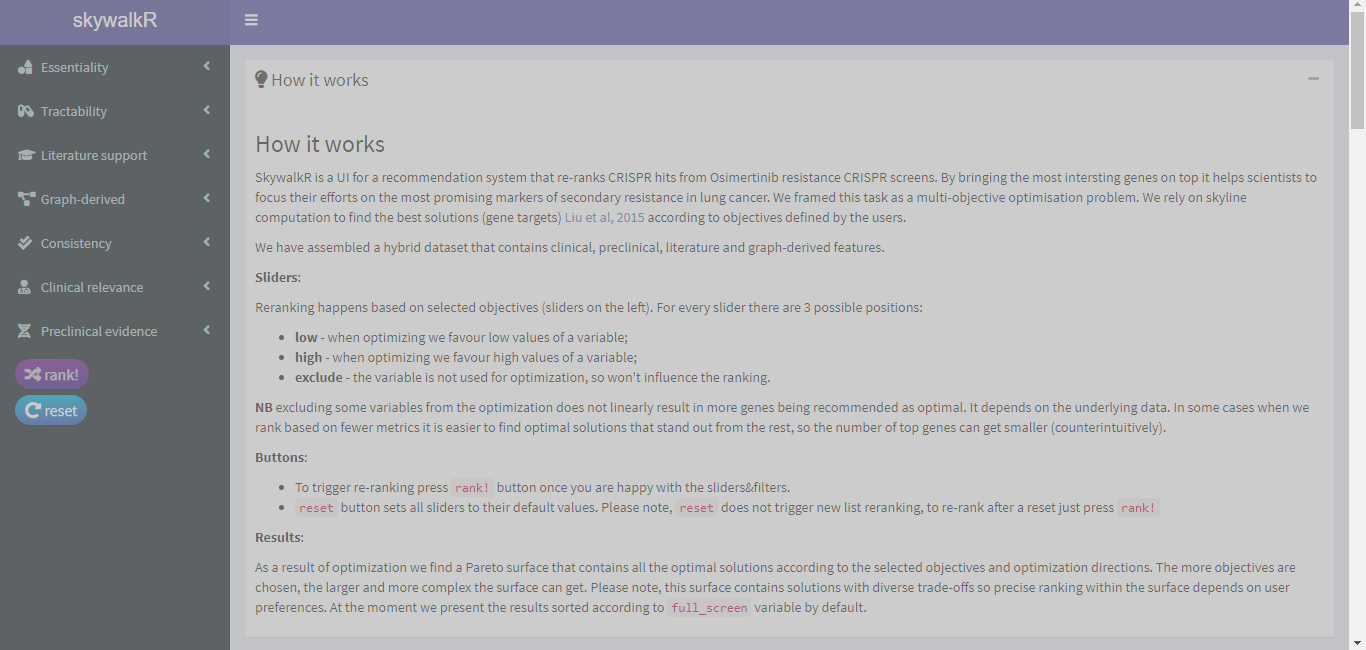

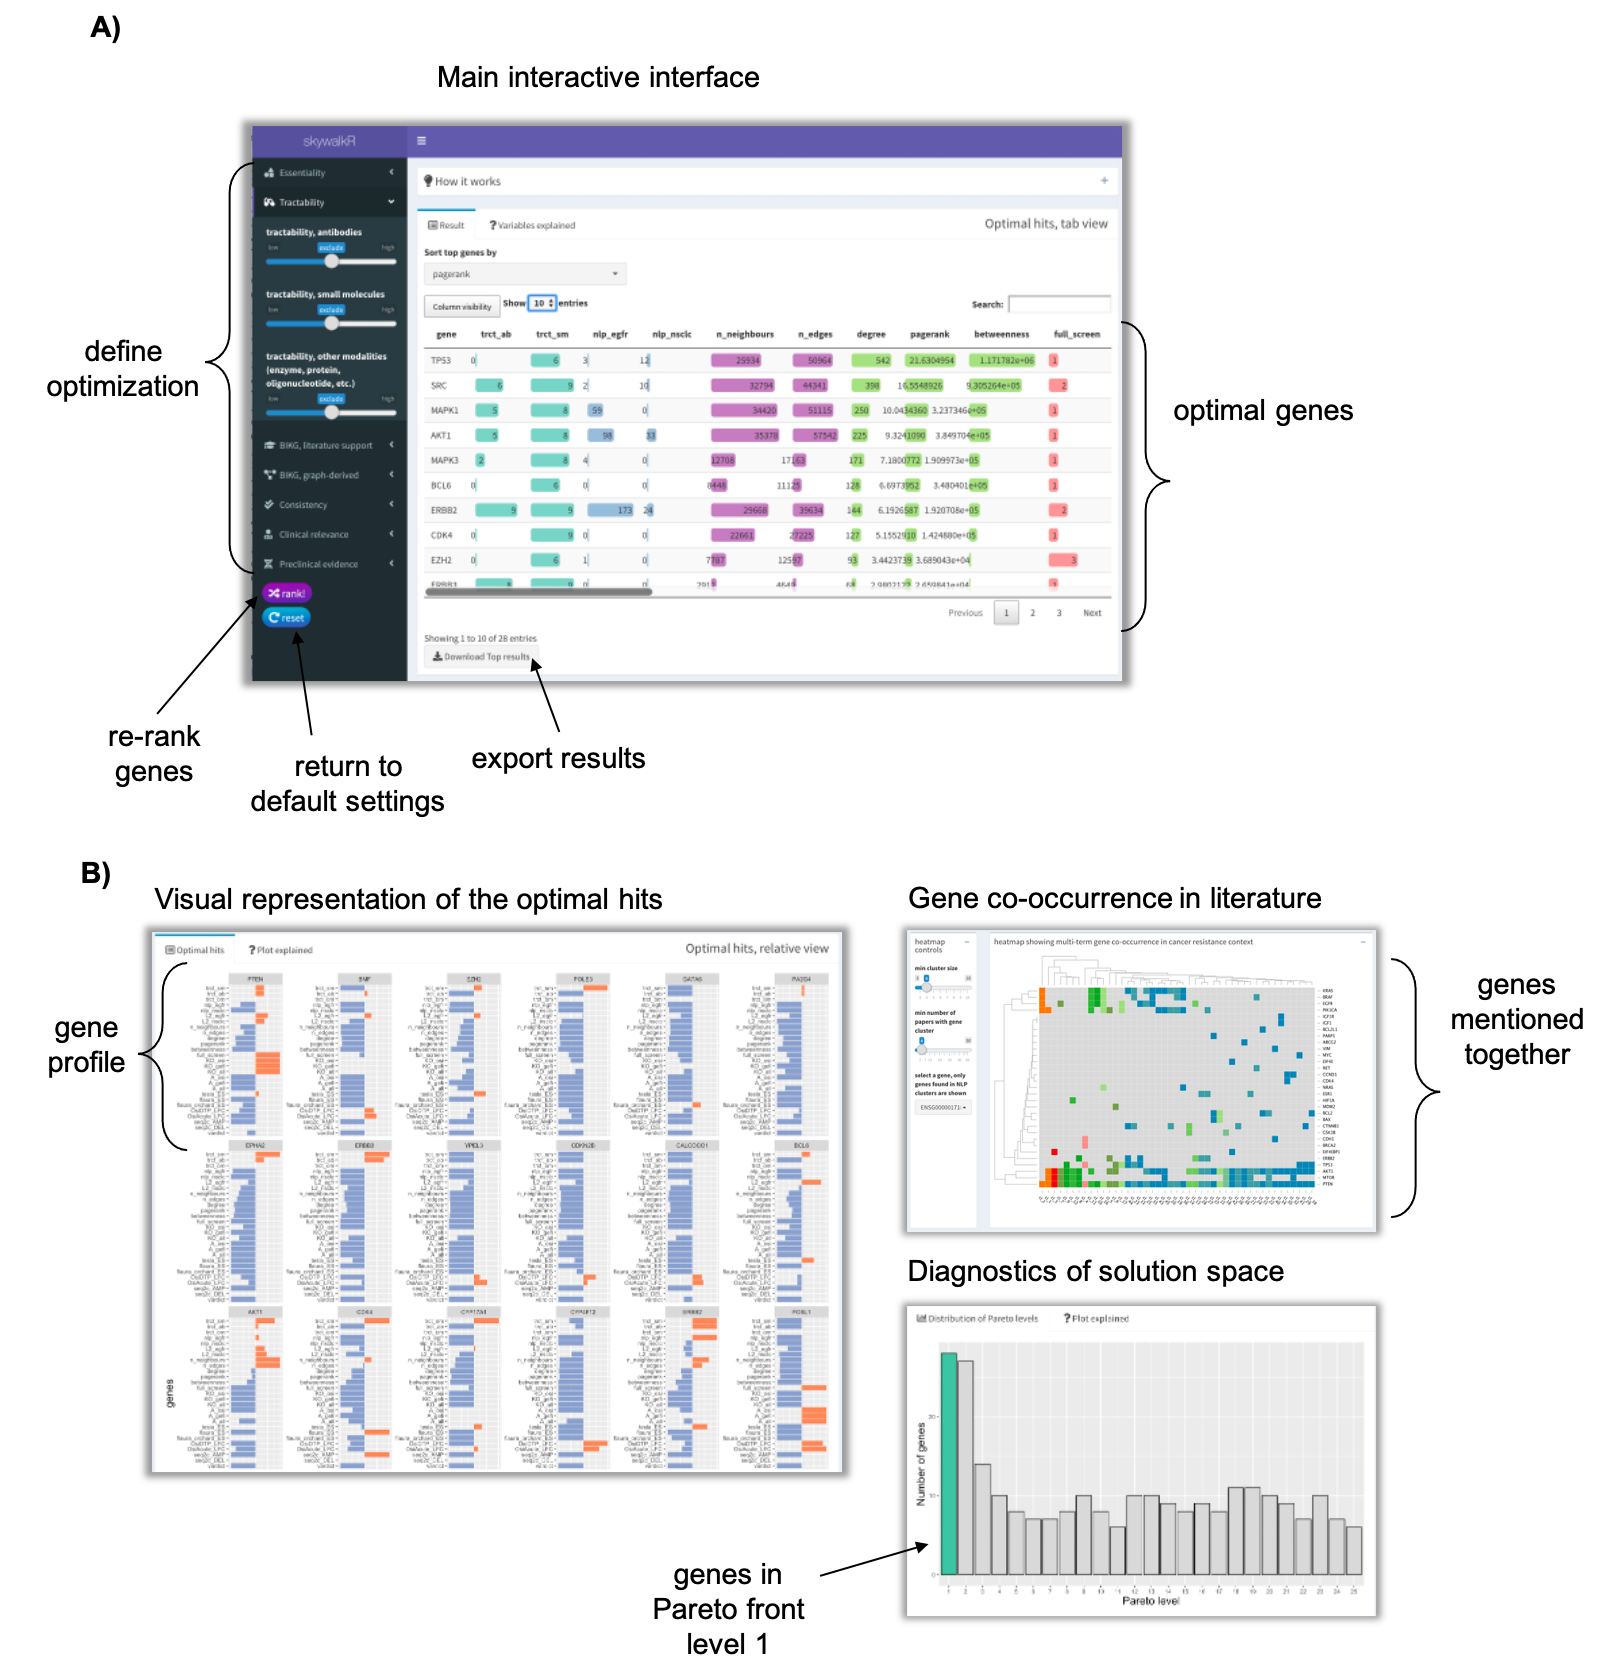

## References

1. [Knowledge Graph-based Recommendation Framework Identifies Novel Drivers of Resistance in EGFR mutant Non-small Cell Lung Cancer](https://www.biorxiv.org/content/10.1101/2021.07.23.453506v2.full.pdf) `paper`
2. [skywalkR](https://github.com/AstraZeneca/skywalkR) `code`